## License 

Copyright 2021 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 1

#### Imports and inits

In [1]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators import *                                  # h2o models
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from h2o.estimators.deeplearning import H2ODeepLearningEstimator # h2o deep learning model
from interpret import show                                    # basic visualizations from interpret package
from interpret.data import ClassHistogram                     # histogram
from interpret.glassbox import *                              # interpret glassboxx models
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python
from rmltk import explain, evaluate, model                    # simple module for training, explaining, and eval
import operator                                               # to sort dictionaries
from imblearn.over_sampling import RandomOverSampler          #Handle class imbalance
from imblearn.under_sampling import RandomUnderSampler        #Handle class imbalance
from imblearn.over_sampling import SMOTE                      #Handle class imbalance
from collections import Counter
# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,9 mins 18 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_adelhassen_6l9tjs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.288 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### Start global timer

In [2]:
global_tic = time.time()

#### Import data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [4]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Basic data exploration

#### Number of rows and columns of our training set

In [5]:
data[x_names].shape

(160338, 10)

#### Variable type of features

In [6]:
data[x_names].dtypes

term_360                          int64
conforming                        int64
debt_to_income_ratio_missing      int64
loan_amount_std                 float64
loan_to_value_ratio_std         float64
no_intro_rate_period_std        float64
intro_rate_period_std           float64
property_value_std              float64
income_std                      float64
debt_to_income_ratio_std        float64
dtype: object

#### Summary Statistics

In [7]:
data[x_names + [y_name]].describe()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
count,160338.000000,160338.000000,160338.000000,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,1.603380e+05,160338.000000
mean,0.960328,0.928027,0.000617,1.518971e-16,3.813309e-16,-1.243723e-15,-6.991775e-15,2.016754e-15,4.592073e-16,9.179888e-16,0.096702
std,0.195189,0.258444,0.024841,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.295552
min,0.000000,0.000000,0.000000,-1.261924e+00,-3.479243e+00,-4.091747e+00,-2.153042e-01,-1.090958e+00,-9.782313e-02,-2.527547e+00,0.000000
25%,1.000000,1.000000,0.000000,-5.583656e-01,-2.753968e-01,2.443944e-01,-2.153042e-01,-5.359324e-01,-3.337777e-02,-4.251308e-01,0.000000
50%,1.000000,1.000000,0.000000,-2.505590e-01,1.792226e-01,2.443944e-01,-2.153042e-01,-2.584194e-01,-2.332984e-02,1.233255e-01,0.000000
75%,1.000000,1.000000,0.000000,2.771095e-01,4.280875e-01,2.443944e-01,-2.153042e-01,1.732675e-01,-7.738221e-03,6.717818e-01,0.000000
max,1.000000,1.000000,1.000000,5.150493e+01,2.027553e+02,2.443944e-01,1.687735e+01,4.084434e+01,3.055430e+02,3.871110e+00,1.000000


#### Histograms

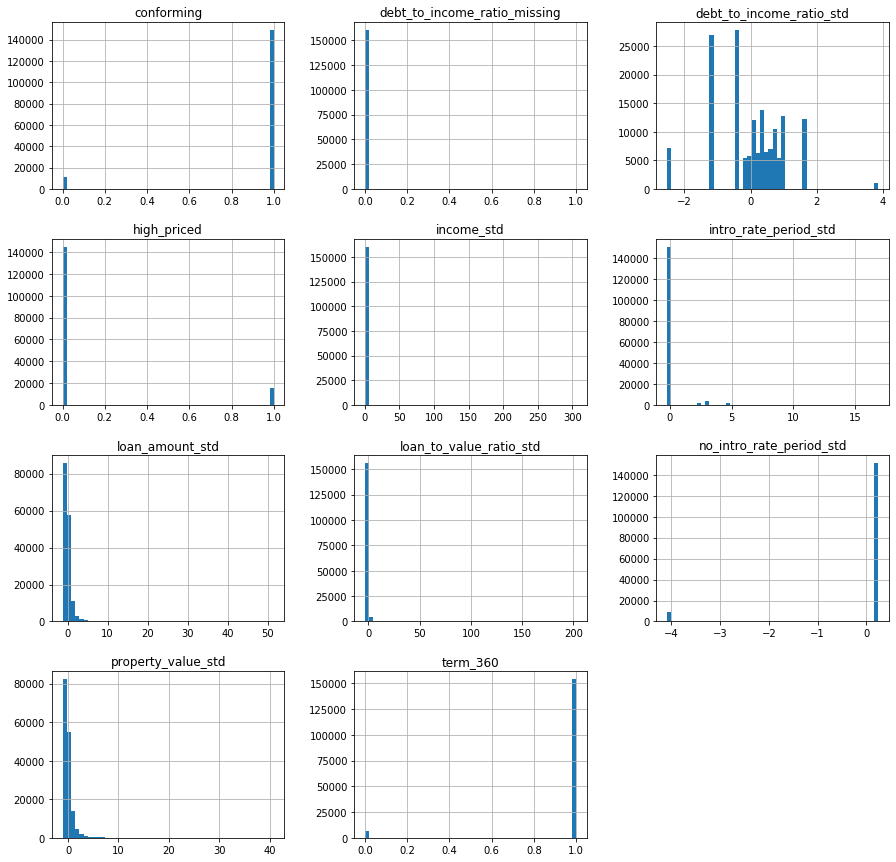

In [8]:
_ = data[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Interactive Histograms

In [9]:
hist = ClassHistogram().explain_data(data[x_names], data[y_name], name = 'Train Data')
show(hist)

<!-- http://127.0.0.1:7411/116600870224/ -->

#### Correlations

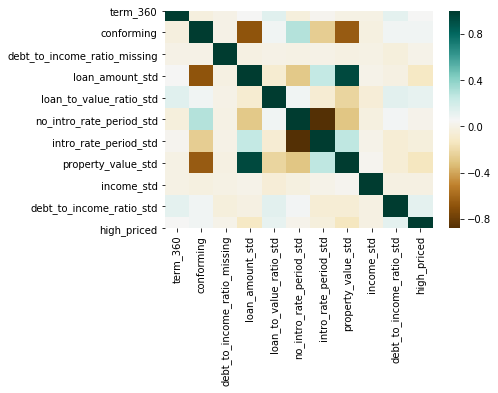

In [10]:
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                cmap = 'BrBG')

#### One way correlation with high_priced

In [11]:
data_for_pric_corrs = data[x_names + [y_name]]

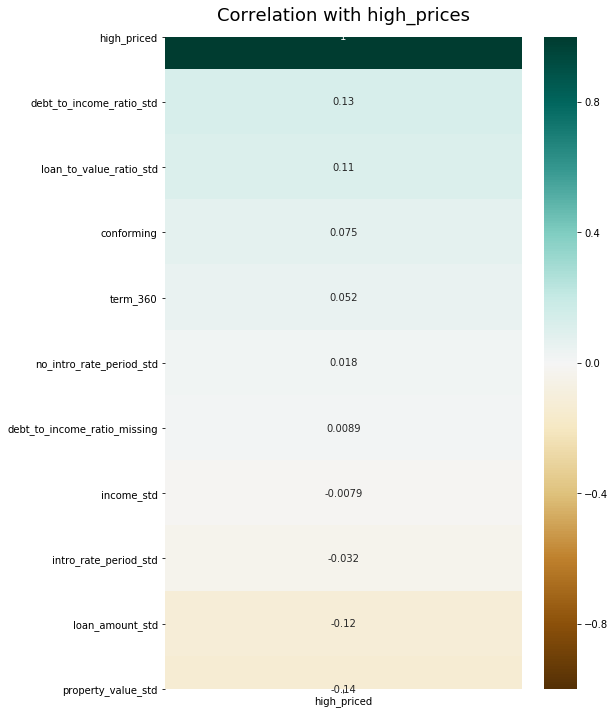

In [12]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_for_pric_corrs.corr()[['high_priced']].sort_values(by='high_priced', ascending=False), vmin = -1, vmax = 1, annot = True, cmap = 'BrBG')

heatmap.set_title('Correlation with high_prices', fontdict={'fontsize':18}, pad=16);

#### Another way to visualize correlation with a focus on direction

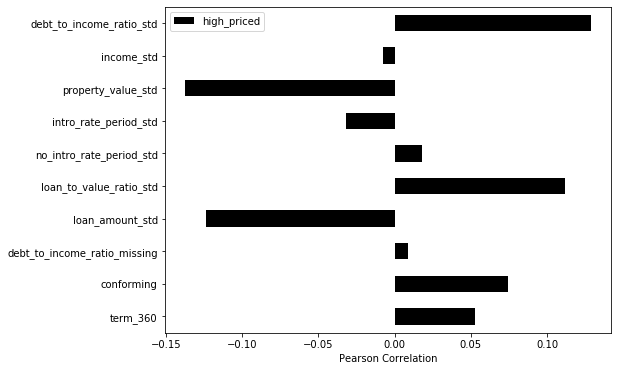

In [13]:
# display correlation to target as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1].plot(kind='barh', ax=ax_, colormap='gnuplot')
_ = ax_.set_xlabel('Pearson Correlation')

In [14]:
# Pearson correlation in a table
corr = pd.DataFrame(data[x_names + [y_name]].corr()[y_name]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']
corr


,Pearson Correlation Coefficient
term_360,0.052448
conforming,0.074543
debt_to_income_ratio_missing,0.008857
loan_amount_std,-0.123545
loan_to_value_ratio_std,0.111540
no_intro_rate_period_std,0.018108
intro_rate_period_std,-0.031716
property_value_std,-0.137319
income_std,-0.007911
debt_to_income_ratio_std,0.128645


#### Accentuate the class imbalance

In [15]:
data.groupby('high_priced').size()

high_priced
0    144833
1     15505
dtype: int64

## Fit interpretable models

#### Split data into train and validation partitions 

In [16]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Elastic net

#### Define wrapper function for grid search

In [17]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      nfolds = 5, #Add 5-fold CV
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [18]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

Elastic net GLM training completed in 78.74 s.


In [19]:
# train penalized GLM w/ alpha and lambda grid search
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

best_glm = model.glm_grid(x_names, y_name, h2o.H2OFrame(train),
                          h2o.H2OFrame(valid), SEED)

# output results
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

# print selected coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM AUC: 0.75
Best penalized GLM coefficients:
Intercept:                -2.582959854751719
property_value_std:       -0.9301938288517535
term_360:                 0.06833329420541565
loan_to_value_ratio_std:  0.18759209790042208
debt_to_income_ratio_std: 0.3309177668970624


In [20]:
best_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_bc1e9cc98078854ce94eae61ef5a4b09.hex_model_python_1622220543852_161_model_4


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.99, lambda = 0.007062 )","nlambda = 100, lambda.max = 0.04136, lambda.min = 0.007062, lambda...",10,4,34,Key_Frame__upload_bc1e9cc98078854ce94eae61ef5a4b09.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.08251332157851757
RMSE: 0.2872513212824574
LogLoss: 0.2899862237861769
Null degrees of freedom: 112252
Residual degrees of freedom: 112248
Null deviance: 71663.33577025973
Residual deviance: 65106.65691132785
AIC: 65116.65691132785
AUC: 0.75477886750561
AUCPR: 0.22457478896616853
Gini: 0.5095577350112199

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12746672433656045: 


,,0,1,Error,Rate
0,0,77763.0,23563.0,0.2325,(23563.0/101326.0)
1,1,4487.0,6440.0,0.4106,(4487.0/10927.0)
2,Total,82250.0,30003.0,0.2499,(28050.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.127467,0.314684,162.0
1,max f2,0.104111,0.466275,206.0
2,max f0point5,0.155256,0.266588,112.0
3,max accuracy,0.394589,0.902684,11.0
4,max precision,0.394589,0.560000,11.0
5,max recall,0.000137,1.000000,399.0
6,max specificity,0.998902,0.999951,0.0
7,max absolute_mcc,0.121369,0.242135,173.0
8,max min_per_class_accuracy,0.115395,0.689851,184.0
9,max mean_per_class_accuracy,0.104111,0.696802,206.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.49 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010156,2.222064e-01,3.181023,3.181023,0.309649,0.266256,0.309649,0.266256,0.032305,0.032305,218.102343,218.102343,0.024538
1,2,0.020837,2.044061e-01,3.170148,3.175449,0.308590,0.211360,0.309106,0.238116,0.033861,0.066166,217.014812,217.544861,0.050218
2,3,0.030298,1.935179e-01,3.047074,3.135362,0.296610,0.198307,0.305204,0.225685,0.028828,0.094994,204.707434,213.536232,0.071673
3,4,0.041754,1.863794e-01,3.067519,3.116748,0.298600,0.189620,0.303392,0.215790,0.035142,0.130136,206.751906,211.674776,0.097914
4,5,0.050413,1.810878e-01,2.663369,3.038875,0.259259,0.183169,0.295812,0.210187,0.023062,0.153198,166.336869,203.887456,0.113870
5,6,0.100060,1.617423e-01,2.376079,2.710014,0.231294,0.170427,0.263800,0.190459,0.117965,0.271163,137.607906,171.001422,0.189555
6,7,0.150081,1.490695e-01,2.168032,2.529375,0.211042,0.155008,0.246216,0.178643,0.108447,0.379610,116.803158,152.937479,0.254282
7,8,0.200280,1.387555e-01,1.894169,2.370164,0.184383,0.143775,0.230718,0.169904,0.095086,0.474696,89.416863,137.016357,0.304009
8,9,0.300028,1.220170e-01,1.627605,2.123291,0.158435,0.129999,0.206687,0.156637,0.162350,0.637046,62.760476,112.329071,0.373362
9,10,0.399998,1.070768e-01,1.158939,1.882273,0.112814,0.114327,0.183225,0.146063,0.115860,0.752906,15.893867,88.227250,0.390965




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.08102911217723614
RMSE: 0.28465612970255205
LogLoss: 0.28586216019335126
Null degrees of freedom: 48084
Residual degrees of freedom: 48080
Null deviance: 30240.36713093873
Residual deviance: 27491.363945794597
AIC: 27501.363945794597
AUC: 0.7538148102147294
AUCPR: 0.2174957161569428
Gini: 0.5076296204294588

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1397132479962921: 


,,0,1,Error,Rate
0,0,36181.0,7326.0,0.1684,(7326.0/43507.0)
1,1,2403.0,2175.0,0.5249,(2403.0/4578.0)
2,Total,38584.0,9501.0,0.2023,(9729.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.139713,0.308971,141.0
1,max f2,0.101551,0.459445,212.0
2,max f0point5,0.163312,0.266580,101.0
3,max accuracy,0.997543,0.904752,0.0
4,max precision,0.400837,0.300000,7.0
5,max recall,0.000124,1.000000,399.0
6,max specificity,0.997543,0.999954,0.0
7,max absolute_mcc,0.120707,0.237725,175.0
8,max min_per_class_accuracy,0.114982,0.688004,186.0
9,max mean_per_class_accuracy,0.101551,0.694660,212.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010045,2.222380e-01,3.044491,3.044491,0.289855,0.267096,0.289855,0.267096,0.030581,0.030581,204.449130,204.449130,0.022697
1,2,0.020589,2.044061e-01,3.066109,3.055562,0.291913,0.211831,0.290909,0.238794,0.032329,0.062910,206.610899,205.556217,0.046774
2,3,0.030009,1.938378e-01,2.805569,2.977082,0.267108,0.198511,0.283437,0.226148,0.026431,0.089340,180.556930,197.708208,0.065574
3,4,0.040033,1.868320e-01,3.116182,3.011911,0.296680,0.190275,0.286753,0.217166,0.031236,0.120577,211.618212,201.191129,0.089019
4,5,0.050099,1.810878e-01,3.233514,3.056434,0.307851,0.183875,0.290992,0.210477,0.032547,0.153124,223.351395,205.643420,0.113866
5,6,0.100010,1.618235e-01,2.455192,2.756376,0.233750,0.170589,0.262425,0.190570,0.122543,0.275666,145.519195,175.637568,0.194139
6,7,0.150317,1.488313e-01,2.032094,2.513980,0.193468,0.155144,0.239347,0.178714,0.102228,0.377894,103.209411,151.397984,0.251524
7,8,0.200624,1.389927e-01,2.010384,2.387702,0.191401,0.143764,0.227325,0.169950,0.101136,0.479030,101.038370,138.770234,0.307701
8,9,0.300198,1.220508e-01,1.559730,2.113069,0.148496,0.130196,0.201178,0.156764,0.155308,0.634338,55.972952,111.306889,0.369300
9,10,0.400021,1.068868e-01,1.177267,1.879544,0.112083,0.114437,0.178945,0.146202,0.117519,0.751857,17.726673,87.954405,0.388858




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-28 13:00:02,0.000 sec,1,.41E-1,1,0.638409,0.628894,0.99,NaN,...,,,,,,,,,,
1,,2021-05-28 13:00:02,0.043 sec,3,.38E-1,3,0.633777,0.624362,0.99,NaN,...,,,,,,,,,,
2,,2021-05-28 13:00:02,0.076 sec,5,.34E-1,3,0.627905,0.618716,0.99,NaN,...,,,,,,,,,,
3,,2021-05-28 13:00:02,0.110 sec,7,.31E-1,3,0.622516,0.613542,0.99,NaN,...,,,,,,,,,,
4,,2021-05-28 13:00:02,0.154 sec,9,.29E-1,3,0.617581,0.608812,0.99,NaN,...,,,,,,,,,,
5,,2021-05-28 13:00:02,0.189 sec,11,.26E-1,3,0.613074,0.604501,0.99,NaN,...,,,,,,,,,,
6,,2021-05-28 13:00:02,0.224 sec,13,.24E-1,4,0.608870,0.600481,0.99,NaN,...,,,,,,,,,,
7,,2021-05-28 13:00:03,0.264 sec,15,.22E-1,4,0.604970,0.596741,0.99,NaN,...,,,,,,,,,,
8,,2021-05-28 13:00:03,0.298 sec,17,.2E-1,4,0.601479,0.593391,0.99,NaN,...,,,,,,,,,,
9,,2021-05-28 13:00:03,0.333 sec,19,.18E-1,4,0.598284,0.590297,0.99,NaN,...,,,,,,,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,property_value_std,0.922198,1.000000,0.625650
1,debt_to_income_ratio_std,0.331101,0.359035,0.224630
2,loan_to_value_ratio_std,0.207438,0.224939,0.140733
3,term_360,0.013247,0.014364,0.008987
4,conforming,0.000000,0.000000,0.000000
5,debt_to_income_ratio_missing,0.000000,0.000000,0.000000
6,loan_amount_std,0.000000,0.000000,0.000000
7,no_intro_rate_period_std,0.000000,0.000000,0.000000
8,intro_rate_period_std,0.000000,0.000000,0.000000
9,income_std,0.000000,0.000000,0.000000


#### Basic AUC assessment

In [21]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7538.


#### We need absolute value of correlation for forwaard stepwise selection

In [22]:
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()


In [23]:
abs_corr

,Pearson Correlation Coefficient
term_360,0.052448
conforming,0.074543
debt_to_income_ratio_missing,0.008857
loan_amount_std,0.123545
loan_to_value_ratio_std,0.111540
no_intro_rate_period_std,0.018108
intro_rate_period_std,0.031716
property_value_std,0.137319
income_std,0.007911
debt_to_income_ratio_std,0.128645


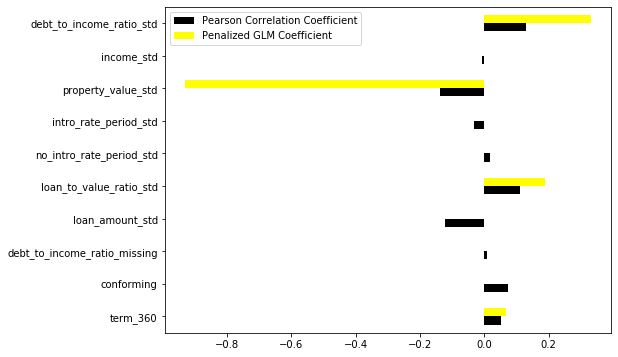

In [24]:
# collect Pearson correlation and GLM coefficients into same DataFrame
glm_selected_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr, glm_selected_coef.iloc[1:]], axis=1)

# plot
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_, colormap='gnuplot')


In [25]:
# initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()

glm_selected = ['property_value_std', 'term_360','loan_to_value_ratio_std','debt_to_income_ratio_std']

# create a list of features to add into MGBM
# list is ordered by correlation between X_j and y
next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in glm_selected]

# create a DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized glm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# start local timer
mgbm_tic = time.time()

# forward stepwise MGBM training
mgbm_train_results = model.gbm_forward_select_train(glm_selected, 
                                                    y_name, 
                                                    train, 
                                                    valid, 
                                                    SEED, 
                                                    next_list,
                                                    abs_corr_glm_mgbm_shap, 
                                                    'Monotonic GBM Mean SHAP Value',
                                                    monotone=True)

mgbm_models = mgbm_train_results['MODELS']
corr_glm_mgbm_shap_coefs = mgbm_train_results['GLOBAL_COEFS']
mgbm_shap = mgbm_train_results['LOCAL_COEFS']

# end local timer
toc = time.time()-mgbm_tic
print('Task completed in %.2f s.' % (toc))

# 2 threads  - 695 s
# 4 threads  - 691 s
# 8 threads  - 692 s
# 24 threads - 713 s

Starting grid search 1/7 ...
Input features = ['property_value_std', 'term_360', 'loan_to_value_ratio_std', 'debt_to_income_ratio_std']
Monotone constraints = {'property_value_std': -1, 'term_360': 1, 'loan_to_value_ratio_std': 1, 'debt_to_income_ratio_std': 1}
Job request failed Unexpected HTTP error: ('Connection aborted.', BadStatusLine('GET /3/Jobs/$03017f00000132d4ffffffff$_8bcf45d1079bbb6b4b5aa82428304594 HTTP/1.1\r\n')), will retry after 3s.
Completed grid search 1/7 with AUC: 0.79 ...
--------------------------------------------------------------------------------
Starting grid search 2/7 ...
Input features = ['property_value_std', 'term_360', 'loan_to_value_ratio_std', 'debt_to_income_ratio_std', 'loan_amount_std']
Monotone constraints = {'property_value_std': -1, 'term_360': 1, 'loan_to_value_ratio_std': 1, 'debt_to_income_ratio_std': 1, 'loan_amount_std': -1}
Completed grid search 2/7 with AUC: 0.79 ...
------------------------------------------------------------------------

In [26]:
best_glm.model_id

'Grid_GLM_Key_Frame__upload_bc1e9cc98078854ce94eae61ef5a4b09.hex_model_python_1622220543852_161_model_4'

In [27]:
# autoph cv_model_rank_select function
# requires models to have model_id 
best_glm.model_id = 'best_glm'
compare_model_ids = ['best_glm'] # list of model_ids

# start local timer
tic = time.time()

# perform CV rank model selection
mgbm_rank_results = evaluate.cv_model_rank_select(valid,
                                                  SEED,
                                                  mgbm_train_results,
                                                  'mgbm',
                                                  compare_model_ids)

best_mgbm = mgbm_rank_results['BEST_MODEL']
best_mgbm_shap = mgbm_rank_results['BEST_LOCAL_COEFS']
mgbm_selected_coefs = mgbm_rank_results['BEST_GLOBAL_COEFS']
best_mgbm_eval = mgbm_rank_results['METRICS']


# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Evaluated model 1/7 with rank: 1.00* ...
Evaluated model 2/7 with rank: 1.00 ...
Evaluated model 3/7 with rank: 1.00 ...
Evaluated model 4/7 with rank: 1.00 ...
Evaluated model 5/7 with rank: 1.00 ...
Evaluated model 6/7 with rank: 1.00 ...
Evaluated model 7/7 with rank: 1.00 ...
Done.
Task completed in 4015.42 s.


In [28]:
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  mgbm1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,301.0,301.0,27814.0,0.0,3.0,0.810631,1.0,8.0,2.421927




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07929034971425854
RMSE: 0.281585421700518
LogLoss: 0.2709975669528318
Mean Per-Class Error: 0.27111685288997245
AUC: 0.7855852102141437
AUCPR: 0.25343991507248576
Gini: 0.5711704204282875

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15640397406774606: 


,,0,1,Error,Rate
0,0,80612.0,20714.0,0.2044,(20714.0/101326.0)
1,1,4477.0,6450.0,0.4097,(4477.0/10927.0)
2,Total,85089.0,27164.0,0.2244,(25191.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.156404,0.338663,165.0
1,max f2,0.101080,0.501480,232.0
2,max f0point5,0.227555,0.286363,100.0
3,max accuracy,0.653754,0.902791,7.0
4,max precision,0.653754,0.608696,7.0
5,max recall,0.004842,1.000000,396.0
6,max specificity,0.797336,0.999990,0.0
7,max absolute_mcc,0.113053,0.279427,215.0
8,max min_per_class_accuracy,0.128009,0.719045,197.0
9,max mean_per_class_accuracy,0.101080,0.728883,232.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.71 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011242,0.365319,3.939880,3.939880,0.383518,0.428431,0.383518,0.428431,0.044294,0.044294,293.988023,293.988023,0.036616
1,2,0.022868,0.331347,3.172426,3.549725,0.308812,0.342571,0.345540,0.384782,0.036881,0.081175,217.242635,254.972545,0.064595
2,3,0.030538,0.311162,3.054456,3.425330,0.297329,0.321458,0.333431,0.368877,0.023428,0.104603,205.445568,242.533010,0.082052
3,4,0.040070,0.283488,3.245114,3.382460,0.315888,0.298805,0.329257,0.352208,0.030933,0.135536,224.511384,238.245962,0.105761
4,5,0.050751,0.272166,2.527551,3.202534,0.246038,0.273626,0.311743,0.335670,0.026997,0.162533,152.755053,220.253405,0.123836
5,6,0.101022,0.233207,2.619677,2.912493,0.255006,0.252661,0.283510,0.294363,0.131692,0.294225,161.967706,191.249331,0.214039
6,7,0.150490,0.200623,2.242188,2.692153,0.218260,0.216792,0.262061,0.268864,0.110918,0.405143,124.218767,169.215310,0.282115
7,8,0.200600,0.175342,2.103909,2.545210,0.204800,0.188975,0.247757,0.248908,0.105427,0.510570,110.390907,154.520964,0.343397
8,9,0.300250,0.135198,1.719206,2.271068,0.167352,0.154003,0.221072,0.217410,0.171319,0.681889,71.920649,127.106796,0.422794
9,10,0.400577,0.099178,1.305332,2.029194,0.127064,0.116347,0.197527,0.192098,0.130960,0.812849,30.533242,102.919380,0.456731




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07787243450965187
RMSE: 0.2790563285604752
LogLoss: 0.26670778792535355
Mean Per-Class Error: 0.27238546238367634
AUC: 0.7866895710419468
AUCPR: 0.2497933485126242
Gini: 0.5733791420838936

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14580792703243753: 


,,0,1,Error,Rate
0,0,33534.0,9973.0,0.2292,(9973.0/43507.0)
1,1,1680.0,2898.0,0.367,(1680.0/4578.0)
2,Total,35214.0,12871.0,0.2423,(11653.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.145808,0.332168,169.0
1,max f2,0.104656,0.494507,222.0
2,max f0point5,0.226889,0.284779,94.0
3,max accuracy,0.598523,0.904898,8.0
4,max precision,0.760381,1.000000,0.0
5,max recall,0.002496,1.000000,399.0
6,max specificity,0.760381,1.000000,0.0
7,max absolute_mcc,0.124486,0.276725,196.0
8,max min_per_class_accuracy,0.127110,0.718597,193.0
9,max mean_per_class_accuracy,0.085413,0.727615,248.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.71 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010897,0.365319,3.948833,3.948833,0.375954,0.429161,0.375954,0.429161,0.043032,0.043032,294.883303,294.883303,0.035516
1,2,0.022606,0.331347,3.358133,3.642886,0.319716,0.342784,0.346826,0.384423,0.039318,0.082350,235.813338,264.288648,0.066031
2,3,0.030009,0.312791,2.861907,3.450212,0.272472,0.322364,0.328482,0.369113,0.021188,0.103539,186.190734,245.021249,0.081266
3,4,0.040907,0.287605,3.447712,3.449546,0.328244,0.299846,0.328419,0.350660,0.037571,0.141110,244.771209,244.954639,0.110747
4,5,0.050390,0.272306,2.902282,3.346553,0.276316,0.273862,0.318613,0.336207,0.027523,0.168633,190.228151,234.655308,0.130685
5,6,0.100198,0.235811,2.530487,2.940891,0.240919,0.254279,0.279992,0.295481,0.126038,0.294670,153.048710,194.089139,0.214936
6,7,0.150484,0.202123,2.232753,2.704258,0.212572,0.218102,0.257463,0.269624,0.112276,0.406946,123.275286,170.425803,0.283449
7,8,0.200665,0.176111,2.063264,2.543960,0.196436,0.190174,0.242201,0.249755,0.103539,0.510485,106.326424,154.395976,0.342420
8,9,0.300322,0.135198,1.746929,2.279479,0.166319,0.154678,0.217021,0.218206,0.174093,0.684578,74.692936,127.947879,0.424689
9,10,0.400062,0.098826,1.265851,2.026770,0.120517,0.115777,0.192961,0.192669,0.126256,0.810834,26.585073,102.676994,0.453995




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-28 13:02:26,2 min 18.796 sec,0.0,0.296424,0.319205,0.500000,0.097343,1.000000,0.902657,0.293508,0.314447,0.500000,0.095206,1.000000,0.904794
1,,2021-05-28 13:02:26,2 min 18.866 sec,1.0,0.295062,0.314721,0.695967,0.181086,2.574180,0.389513,0.292132,0.309954,0.700228,0.179516,2.631769,0.389643
2,,2021-05-28 13:02:26,2 min 18.939 sec,2.0,0.293142,0.308574,0.759023,0.220073,3.254178,0.280759,0.290212,0.303865,0.761370,0.217881,3.286673,0.280982
3,,2021-05-28 13:02:26,2 min 19.006 sec,3.0,0.291464,0.303344,0.772445,0.237865,3.246218,0.266202,0.288581,0.298807,0.773025,0.233544,3.260675,0.267672
4,,2021-05-28 13:02:26,2 min 19.074 sec,4.0,0.290233,0.299530,0.771735,0.237316,3.231088,0.233544,0.287344,0.294990,0.772926,0.233681,3.252878,0.235354
5,,2021-05-28 13:02:26,2 min 19.143 sec,5.0,0.289167,0.296161,0.773087,0.242847,3.576186,0.195202,0.286312,0.291719,0.773636,0.237924,3.590480,0.196901
6,,2021-05-28 13:02:27,2 min 19.216 sec,6.0,0.288513,0.293935,0.771787,0.241992,3.616094,0.195291,0.285663,0.289504,0.772565,0.237889,3.582723,0.197088
7,,2021-05-28 13:02:27,2 min 19.288 sec,7.0,0.287774,0.291576,0.772517,0.244862,3.465066,0.195282,0.284947,0.287201,0.773618,0.241555,3.809669,0.197047
8,,2021-05-28 13:02:27,2 min 19.357 sec,8.0,0.287037,0.289513,0.774629,0.244906,3.488775,0.196895,0.284187,0.285091,0.776274,0.242507,3.400722,0.199064
9,,2021-05-28 13:02:27,2 min 19.437 sec,9.0,0.286512,0.287774,0.774663,0.244671,3.460828,0.209259,0.283686,0.283398,0.776158,0.242471,3.418923,0.211272



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,2347.404785,1.000000,0.493068
1,property_value_std,1619.256226,0.689807,0.340122
2,debt_to_income_ratio_std,770.273315,0.328138,0.161795
3,term_360,23.877335,0.010172,0.005015


#### Basic AUC Assessment

In [29]:
print('Validation AUC: %.4f.' % best_mgbm.auc(valid=True))

Validation AUC: 0.7867.


In [30]:
best_mgbm_eval

,Fold,Metric,best_glm Value,mgbm1 Value,best_glm Rank,mgbm1 Rank
0,0,F1,0.294460,0.324174,2.0,1.0
1,0,accuracy,0.906449,0.906552,2.0,1.0
2,0,auc,0.747561,0.785675,2.0,1.0
3,0,logloss,0.281304,0.263966,2.0,1.0
4,0,mcc,0.226713,0.272256,2.0,1.0
5,1,F1,0.310032,0.331547,2.0,1.0
6,1,accuracy,0.905826,0.906137,2.0,1.0
7,1,auc,0.755567,0.788831,2.0,1.0
8,1,logloss,0.282457,0.264281,2.0,1.0
9,1,mcc,0.234928,0.279101,2.0,1.0


In [31]:
print('Best GLM mean rank:', best_mgbm_eval['best_glm Rank'].mean())
print('Best MGBM mean rank:', best_mgbm_eval['mgbm1 Rank'].mean())

Best GLM mean rank: 2.0
Best MGBM mean rank: 1.0


#### Write submission file

In [32]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_glm_submit.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_submit.columns = ['phat']
best_glm_submit.to_csv('ph_best_glm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### Monotonic XGBoost

#### Define utility function for random grid search

In [33]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

#### Fit monotonic XGBoost with random grid search

In [34]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.7910.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 21/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 22/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel':

---------- ----------
Grid search run 40/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 42/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, '

#### Basic AUC assessment

In [35]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7921.


#### Write submission file

In [36]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit.to_csv('ph_best_mxgb_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                        index=False)

/Users/adelhassen/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



### Explainable Boosting Machine

#### Define utility function for random grid search

In [37]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

#### Fit EBM with random grid search

In [38]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8217.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

#### Basic AUC assessment

In [39]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8247.


In [40]:
train.groupby('high_priced').size()

high_priced
0    101326
1     10927
dtype: int64

#### Fitting models after addressing class imbalance

In [44]:
#Oversampling
rus = RandomOverSampler(random_state = SEED) 
# resampling X, y
X_train, y_train = rus.fit_resample(train[x_names], train[y_name])
# new class distribution
print(Counter(y_train))

Counter({0: 101326, 1: 101326})


In [47]:
train1 = pd.concat([X_train,y_train],axis=1)
train1

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,1,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
1,1,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
2,1,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
3,1,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0
4,1,1,0,-0.338504,0.372784,0.244394,-0.215304,-0.412593,-0.024716,0.397554,0
...,...,...,...,...,...,...,...,...,...,...,...
202647,1,1,0,-0.514393,0.552520,0.244394,-0.215304,-0.566767,-0.037189,0.580372,1
202648,1,1,0,-0.998089,0.552520,0.244394,-0.215304,-0.905950,-0.037536,-0.425131,1
202649,1,1,0,1.508336,0.429037,0.244394,-0.215304,0.913302,-0.016747,0.946010,1
202650,1,1,0,-0.338504,0.057330,0.244394,-0.215304,-0.350924,-0.024716,1.037419,1


#### Random oversampling EBM

In [50]:
ebm1 = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm1.fit(X_train, y_train) _

ExplainableBoostingClassifier(feature_names=['term_360', 'conforming',
                                             'debt_to_income_ratio_missing',
                                             'loan_amount_std',
                                             'loan_to_value_ratio_std',
                                             'no_intro_rate_period_std',
                                             'intro_rate_period_std',
                                             'property_value_std', 'income_std',
                                             'debt_to_income_ratio_std',
                                             'loan_to_value_ratio_std x '
                                             'no_intro_rate_period_std',
                                             'loan_to_value_ratio_std x '
                                             'intro_rate_per...
                                             'property_value_std x income_std'],
                              feature_types=['categor

In [51]:
ebm_perf = ROC(ebm1.predict_proba).explain_perf(valid[x_names], valid[y_name], name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7411/116542755984/ -->

#### Basic AUC assessment

In [52]:
print('Validation AUC: %.6f.' % ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.824732.


#### Random undersampling EBM

In [53]:
#Undersampling
rus = RandomUnderSampler(random_state = SEED) 
# resampling X, y
X_train1, y_train1 = rus.fit_resample(train[x_names], train[y_name])
# new class distribution
print(Counter(y_train1))

Counter({0: 10927, 1: 10927})


In [54]:
ebm2 = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm2.fit(X_train1, y_train1) 

ExplainableBoostingClassifier(feature_names=['term_360', 'conforming',
                                             'debt_to_income_ratio_missing',
                                             'loan_amount_std',
                                             'loan_to_value_ratio_std',
                                             'no_intro_rate_period_std',
                                             'intro_rate_period_std',
                                             'property_value_std', 'income_std',
                                             'debt_to_income_ratio_std',
                                             'loan_to_value_ratio_std x '
                                             'no_intro_rate_period_std',
                                             'loan_to_value_ratio_std x '
                                             'intro_rate_per...
                                             'income_std x '
                                             'debt_to_income_ratio_std'],

In [55]:
ebm_perf2 = ROC(ebm2.predict_proba).explain_perf(valid[x_names], valid[y_name], name='EBM')
show(ebm_perf2)

<!-- http://127.0.0.1:7411/116658013200/ -->

#### Basic AUC assessment

In [56]:
print('Validation AUC: %.6f.' % ebm_perf2._internal_obj['overall']['auc'])

Validation AUC: 0.822985.


#### SMOTE oversampling

In [58]:
sm = SMOTE(random_state=SEED)
# resampling X, y
X_train3, y_train3 = sm.fit_resample(train[x_names], train[y_name])
# new class distribution
print(Counter(y_train3))

Counter({0: 101326, 1: 101326})


In [59]:
ebm3 = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm3.fit(X_train3, y_train3)

ExplainableBoostingClassifier(feature_names=['term_360', 'conforming',
                                             'debt_to_income_ratio_missing',
                                             'loan_amount_std',
                                             'loan_to_value_ratio_std',
                                             'no_intro_rate_period_std',
                                             'intro_rate_period_std',
                                             'property_value_std', 'income_std',
                                             'debt_to_income_ratio_std',
                                             'loan_to_value_ratio_std x '
                                             'no_intro_rate_period_std',
                                             'loan_to_value_ratio_std x '
                                             'intro_rate_per...
                                             'loan_to_value_ratio_std x '
                                             'debt_to_income

In [60]:
ebm_perf3 = ROC(ebm3.predict_proba).explain_perf(valid[x_names], valid[y_name], name='EBM')
show(ebm_perf3)

<!-- http://127.0.0.1:7411/116690039056/ -->

#### Basic AUC assessment

In [61]:
print('Validation AUC: %.4f.' % ebm_perf3._internal_obj['overall']['auc'])

Validation AUC: 0.8168.


### Logistic Regression

In [62]:
lr = LogisticRegression(random_state=SEED, feature_names=x_names, penalty='l2', solver='liblinear')
lr.fit(train[x_names], train[y_name])

In [63]:
lr_perf = ROC(lr.predict_proba).explain_perf(valid[x_names], valid[y_name], name='Classification LR')

In [64]:
show(lr_perf)

<!-- http://127.0.0.1:7411/116706011472/ -->

#### Basic AUC assessment

In [65]:
print('Validation AUC: %.4f.' % lr_perf._internal_obj['overall']['auc'])

Validation AUC: 0.7697.


### Decision Tree

In [66]:
tree = ClassificationTree(random_state=SEED)
tree.fit(train[x_names], train[y_name])

In [67]:
tree_perf = ROC(tree.predict_proba).explain_perf(valid[x_names], valid[y_name], name='Classification Tree')

In [68]:
show(tree_perf)

<!-- http://127.0.0.1:7411/116630137040/ -->

#### Basic AUC assessment

In [69]:
print('Validation AUC: %.4f.' % tree_perf._internal_obj['overall']['auc'])

Validation AUC: 0.7702.


### Naive Bayes

In [70]:
# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

In [71]:
htrain["high_priced"] = htrain["high_priced"].asfactor()
hvalid["high_priced"] = hvalid["high_priced"].asfactor()

In [72]:
htrain["high_priced"] = htrain["high_priced"].asfactor()
hvalid["high_priced"] = hvalid["high_priced"].asfactor()

pros_nb = H2ONaiveBayesEstimator(laplace=0,
                                 nfolds=5,
                                 seed=SEED)
pros_nb.train(x=x_names,
              y=y_name, 
              training_frame=htrain,
              validation_frame = hvalid)


In [73]:
pros_nb

Model Details
H2ONaiveBayesEstimator :  Naive Bayes
Model Key:  NaiveBayes_model_python_1622220543852_11255


Model Summary: 


,,number_of_response_levels,min_apriori_probability,max_apriori_probability
0,,2.0,0.097343,0.902657




ModelMetricsBinomial: naivebayes
** Reported on train data. **

MSE: 0.5686607335166397
RMSE: 0.7540959710253329
LogLoss: 2.193888373069045
Mean Per-Class Error: 0.30250653943787287
AUC: 0.745109516069865
AUCPR: 0.2241487709429801
Gini: 0.49021903213972995

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9800007279838067: 


,,0,1,Error,Rate
0,0,80703.0,20623.0,0.2035,(20623.0/101326.0)
1,1,5012.0,5915.0,0.4587,(5012.0/10927.0)
2,Total,85715.0,26538.0,0.2284,(25635.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.980001,0.315761,19.0
1,max f2,0.962945,0.467002,42.0
2,max f0point5,0.985475,0.268404,10.0
3,max accuracy,1.000000,0.902176,0.0
4,max precision,0.990124,0.326996,2.0
5,max recall,0.000012,1.000000,399.0
6,max specificity,1.000000,0.999447,0.0
7,max absolute_mcc,0.973733,0.245097,29.0
8,max min_per_class_accuracy,0.972990,0.693054,30.0
9,max mean_per_class_accuracy,0.962945,0.697493,42.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score: 69.79 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010040,9.902786e-01,3.208601,3.208601,0.312334,9.910166e-01,0.312334,0.991017,0.032214,0.032214,220.860134,220.860134,0.024565
1,2,0.020008,9.898807e-01,3.424331,3.316082,0.333333,9.901007e-01,0.322796,0.990560,0.034136,0.066349,242.433117,231.608205,0.051338
2,3,0.030004,9.889781e-01,3.122184,3.251488,0.303922,9.894050e-01,0.316508,0.990175,0.031207,0.097557,212.218430,225.148785,0.074838
3,4,0.040008,9.883898e-01,2.533944,3.072062,0.246661,9.886469e-01,0.299043,0.989793,0.025350,0.122907,153.394408,207.206196,0.091839
4,5,0.050003,9.878423e-01,2.820037,3.021684,0.274510,9.881405e-01,0.294139,0.989463,0.028187,0.151094,182.003743,202.168400,0.111992
5,6,0.100006,9.859013e-01,2.445166,2.733425,0.238019,9.868225e-01,0.266079,0.988143,0.122266,0.273360,144.516646,173.342523,0.192048
6,7,0.150000,9.839363e-01,2.171021,2.545979,0.211333,9.849228e-01,0.247832,0.987070,0.108538,0.381898,117.102108,154.597944,0.256905
7,8,0.200004,9.817498e-01,1.965650,2.400891,0.191342,9.828925e-01,0.233709,0.986025,0.098289,0.480187,96.565028,140.089069,0.310398
8,9,0.300010,9.763195e-01,1.618825,2.140194,0.157581,9.789756e-01,0.208332,0.983675,0.161893,0.642079,61.882465,114.019427,0.378958
9,10,0.399998,9.651341e-01,1.107477,1.882044,0.107805,9.709304e-01,0.183203,0.980489,0.110735,0.752814,10.747703,88.204371,0.390864




ModelMetricsBinomial: naivebayes
** Reported on validation data. **

MSE: 0.5669212908939582
RMSE: 0.7529417579693387
LogLoss: 2.1838847339338794
Mean Per-Class Error: 0.298239667533452
AUC: 0.7468813462706568
AUCPR: 0.21811938928498137
Gini: 0.49376269254131366

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.980666062739968: 


,,0,1,Error,Rate
0,0,34917.0,8590.0,0.1974,(8590.0/43507.0)
1,1,2175.0,2403.0,0.4751,(2175.0/4578.0)
2,Total,37092.0,10993.0,0.2239,(10765.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.980666,0.308651,20.0
1,max f2,0.963820,0.466621,45.0
2,max f0point5,0.984383,0.261985,13.0
3,max accuracy,1.000000,0.904419,0.0
4,max precision,0.989843,0.323148,3.0
5,max recall,0.000011,1.000000,399.0
6,max specificity,1.000000,0.999586,0.0
7,max absolute_mcc,0.971483,0.243908,35.0
8,max min_per_class_accuracy,0.972999,0.693753,33.0
9,max mean_per_class_accuracy,0.963820,0.701760,45.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score: 69.42 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010024,9.902803e-01,3.246931,3.246931,0.309129,9.909020e-01,0.309129,0.990902,0.032547,0.032547,224.693102,224.693102,0.024893
1,2,0.020006,9.898703e-01,3.457400,3.351947,0.329167,9.900920e-01,0.319127,0.990498,0.034513,0.067060,245.740043,235.194694,0.052005
2,3,0.030009,9.889281e-01,2.926130,3.210008,0.278586,9.893537e-01,0.305613,0.990116,0.029270,0.096330,192.612958,221.000782,0.073299
3,4,0.040012,9.883830e-01,2.947966,3.144497,0.280665,9.886119e-01,0.299376,0.989740,0.029489,0.125819,194.796637,214.449746,0.094836
4,5,0.050016,9.878552e-01,2.314700,2.978538,0.220374,9.881465e-01,0.283576,0.989422,0.023154,0.148973,131.469952,197.853787,0.109371
5,6,0.100010,9.858995e-01,2.333139,2.655906,0.222130,9.868454e-01,0.252859,0.988134,0.116645,0.265618,133.313907,165.590557,0.183034
6,7,0.150005,9.839775e-01,2.346247,2.552700,0.223378,9.849689e-01,0.243033,0.987079,0.117300,0.382918,134.624659,155.270022,0.257421
7,8,0.200000,9.818435e-01,1.795731,2.363478,0.170965,9.829379e-01,0.225018,0.986044,0.089777,0.472696,79.573063,136.347750,0.301390
8,9,0.300094,9.763066e-01,1.643285,2.123264,0.156451,9.790405e-01,0.202148,0.983708,0.164482,0.637178,64.328521,112.326368,0.372554
9,10,0.400000,9.649649e-01,1.226574,1.899301,0.116778,9.708859e-01,0.180826,0.980505,0.122543,0.759720,22.657383,89.930100,0.397572




ModelMetricsBinomial: naivebayes
** Reported on cross-validation data. **

MSE: 0.5723820760903864
RMSE: 0.7565593671949257
LogLoss: 2.2964663682753867
Mean Per-Class Error: 0.3148215434817798
AUC: 0.718874122473604
AUCPR: 0.18577781854852324
Gini: 0.4377482449472081

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9758027547019528: 


,,0,1,Error,Rate
0,0,72217.0,29109.0,0.2873,(29109.0/101326.0)
1,1,4083.0,6844.0,0.3737,(4083.0/10927.0)
2,Total,76300.0,35953.0,0.2957,(33192.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.975803,0.291980,32.0
1,max f2,0.955689,0.453975,54.0
2,max f0point5,0.979756,0.224693,27.0
3,max accuracy,0.999994,0.902194,0.0
4,max precision,0.997377,0.281865,1.0
5,max recall,0.000018,1.000000,399.0
6,max specificity,0.999994,0.999467,0.0
7,max absolute_mcc,0.967299,0.223931,42.0
8,max min_per_class_accuracy,0.972545,0.676894,36.0
9,max mean_per_class_accuracy,0.966412,0.685178,43.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score: 70.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,9.971255e-01,3.000483,3.000483,0.292075,9.975808e-01,0.292075,0.997581,0.030017,0.030017,200.048252,200.048252,0.022171
1,2,0.020017,9.966591e-01,2.568248,2.784269,0.250000,9.968757e-01,0.271028,0.997228,0.025716,0.055734,156.824838,178.426927,0.039568
2,3,0.030004,9.961917e-01,2.181064,2.583499,0.212310,9.964342e-01,0.251485,0.996964,0.021781,0.077514,118.106374,158.349926,0.052634
3,4,0.040008,9.956842e-01,1.829563,2.394973,0.178094,9.959475e-01,0.233133,0.996710,0.018303,0.095818,82.956251,139.497310,0.061828
4,5,0.050003,9.949411e-01,1.629762,2.242013,0.158645,9.953546e-01,0.218243,0.996439,0.016290,0.112108,62.976189,124.201266,0.068802
5,6,0.100006,9.894887e-01,1.500776,1.871394,0.146089,9.923415e-01,0.182166,0.994390,0.075043,0.187151,50.077582,87.139424,0.096543
6,7,0.150000,9.858104e-01,2.288176,2.010305,0.222737,9.874466e-01,0.195688,0.992076,0.114396,0.301547,128.817567,101.030488,0.167889
7,8,0.200004,9.830850e-01,2.128539,2.039865,0.207198,9.844275e-01,0.198566,0.990164,0.106434,0.407980,112.853936,103.986482,0.230405
8,9,0.300001,9.769236e-01,1.867900,1.982545,0.181826,9.801193e-01,0.192986,0.986816,0.186785,0.594765,86.790020,98.254498,0.326552
9,10,0.399998,9.667329e-01,1.397493,1.836285,0.136036,9.725028e-01,0.178749,0.983238,0.139746,0.734511,39.749319,83.628529,0.370586




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.77666104,0.014530842,0.79231006,0.78853095,0.7789609,0.763864,0.7596393
1,auc,0.74522054,0.0029055825,0.7430661,0.7448719,0.7487368,0.7475539,0.74187416
2,err,0.22333896,0.014530842,0.20768991,0.21146905,0.22103909,0.23613603,0.24036069
3,err_count,5013.8,321.27356,4667.0,4746.0,4982.0,5263.0,5411.0
4,f0point5,0.25573984,0.003542572,0.259106,0.2507837,0.25592458,0.2590196,0.25386533
5,f1,0.31766817,0.0064055817,0.31578946,0.3079615,0.31809473,0.32465032,0.32184485
6,f2,0.4195331,0.01799004,0.40421858,0.39891207,0.420162,0.43482745,0.4395454
7,lift_top_group,3.3734932,0.2963992,3.456545,3.8472373,3.1194324,3.1524565,3.291795
8,logloss,2.295576,0.46094853,2.2038922,1.9271837,3.0972748,2.0762799,2.1732495
9,max_per_class_error,0.46571252,0.037997894,0.50299954,0.50329256,0.46550137,0.43802753,0.41874152


### Random Forest

In [74]:
price_drf = H2ORandomForestEstimator(ntrees=10,
                                    max_depth=5,
                                    min_rows=10,
                                    calibrate_model=True,
                                    calibration_frame=hvalid,
                                    binomial_double_trees=True,
                                    seed=SEED)
price_drf.train(x=x_names, y=y_name, training_frame=htrain, validation_frame = hvalid)


In [75]:
price_drf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1622220543852_11274


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,10.0,20.0,8721.0,5.0,5.0,5.0,26.0,32.0,30.1




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07960315913891274
RMSE: 0.2821403181732677
LogLoss: 0.2710959617115517
Mean Per-Class Error: 0.2735684702431509
AUC: 0.7883072541981913
AUCPR: 0.24964220029771964
Gini: 0.5766145083963825

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16023945141332793: 


,,0,1,Error,Rate
0,0,79465.0,20822.0,0.2076,(20822.0/100287.0)
1,1,4478.0,6345.0,0.4137,(4478.0/10823.0)
2,Total,83943.0,27167.0,0.2277,(25300.0/111110.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160239,0.334035,174.0
1,max f2,0.100028,0.498450,249.0
2,max f0point5,0.203539,0.283181,121.0
3,max accuracy,0.516708,0.902610,4.0
4,max precision,0.611111,1.000000,0.0
5,max recall,0.006697,1.000000,395.0
6,max specificity,0.611111,1.000000,0.0
7,max absolute_mcc,0.110191,0.272840,234.0
8,max min_per_class_accuracy,0.131425,0.714320,208.0
9,max mean_per_class_accuracy,0.100028,0.726432,249.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.63 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.294820,3.640829,3.640829,0.354408,0.325543,0.354408,0.325543,0.036424,0.036424,264.082940,264.082940,0.029268
1,2,0.020008,0.272328,3.595090,3.617960,0.349955,0.282399,0.352182,0.303971,0.035966,0.072389,259.509034,261.795987,0.058030
2,3,0.030013,0.258018,3.046222,3.427380,0.296527,0.264497,0.333630,0.290813,0.030475,0.102864,204.622158,242.738044,0.080708
3,4,0.040008,0.245410,2.975689,3.314533,0.289661,0.251381,0.322645,0.280961,0.029743,0.132607,197.568885,231.453297,0.102585
4,5,0.050039,0.236116,2.600180,3.171332,0.253108,0.240840,0.308706,0.272919,0.026082,0.158689,160.018042,217.133180,0.120368
5,6,0.100006,0.209634,2.553138,2.862455,0.248529,0.221883,0.278639,0.247419,0.127574,0.286263,155.313834,186.245534,0.206343
6,7,0.150000,0.191258,2.268040,2.664340,0.220777,0.200363,0.259354,0.231736,0.113389,0.399652,126.803973,166.434034,0.276574
7,8,0.200012,0.173424,2.016537,2.502361,0.196295,0.182127,0.243586,0.219331,0.100851,0.500503,101.653702,150.236066,0.332896
8,9,0.300010,0.139213,1.715064,2.239944,0.166949,0.156705,0.218042,0.198457,0.171502,0.672005,71.506368,123.994392,0.412111
9,10,0.400007,0.105730,1.307805,2.006919,0.127305,0.121983,0.195359,0.179339,0.130777,0.802782,30.780470,100.691949,0.446210




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.07761082691058346
RMSE: 0.27858719803785575
LogLoss: 0.264574780331991
Mean Per-Class Error: 0.26166063995787914
AUC: 0.7987557136048057
AUCPR: 0.25439990773188226
Gini: 0.5975114272096114

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.156580709588138: 


,,0,1,Error,Rate
0,0,34749.0,8758.0,0.2013,(8758.0/43507.0)
1,1,1869.0,2709.0,0.4083,(1869.0/4578.0)
2,Total,36618.0,11467.0,0.221,(10627.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.156581,0.337675,106.0
1,max f2,0.096064,0.505490,190.0
2,max f0point5,0.198181,0.285101,58.0
3,max accuracy,0.321497,0.904898,11.0
4,max precision,0.417372,0.583333,2.0
5,max recall,0.007828,1.000000,399.0
6,max specificity,0.461759,0.999885,0.0
7,max absolute_mcc,0.096064,0.282333,190.0
8,max min_per_class_accuracy,0.133813,0.715195,136.0
9,max mean_per_class_accuracy,0.095535,0.738339,191.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.72 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.016096,0.281117,3.718292,3.718292,0.354005,0.297421,0.354005,0.297421,0.059851,0.059851,271.829150,271.829150,0.048359
1,2,0.020526,0.268570,3.303916,3.628867,0.314554,0.270447,0.345491,0.291600,0.014635,0.074487,230.391626,262.886706,0.059638
2,3,0.030113,0.256292,3.873306,3.706689,0.368764,0.263502,0.352901,0.282655,0.037134,0.111621,287.330617,270.668918,0.090084
3,4,0.040012,0.225959,2.890668,3.504804,0.275210,0.245013,0.333680,0.273342,0.028615,0.140236,189.066773,250.480446,0.110769
4,5,0.064490,0.225952,2.641491,3.177129,0.251487,0.225952,0.302483,0.255355,0.064657,0.204893,164.149067,217.712941,0.155177
5,6,0.106249,0.204774,2.421872,2.880289,0.230578,0.213530,0.274222,0.238916,0.101136,0.306029,142.187160,188.028899,0.220801
6,7,0.150130,0.194442,2.339641,2.722266,0.222749,0.198518,0.259177,0.227109,0.102665,0.408694,133.964106,172.226612,0.285771
7,8,0.211708,0.174915,2.071611,2.533014,0.197231,0.181974,0.241159,0.213980,0.127567,0.536260,107.161130,153.301377,0.358703
8,9,0.300821,0.141783,1.742820,2.298933,0.165928,0.152113,0.218873,0.195653,0.155308,0.691568,74.282029,129.893295,0.431863
9,10,0.402912,0.102006,1.313739,2.049304,0.125076,0.123084,0.195107,0.177266,0.134120,0.825688,31.373924,104.930376,0.467263




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-28 15:44:22,0.167 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-05-28 15:44:23,0.739 sec,1.0,0.281118,0.268183,0.784767,0.236601,2.964346,0.205760,0.279843,0.266336,0.782234,0.232807,3.175742,0.209130
2,,2021-05-28 15:44:23,1.045 sec,2.0,0.283807,0.276490,0.767408,0.228681,3.146985,0.264019,0.280152,0.268838,0.780661,0.237531,3.409989,0.195466
3,,2021-05-28 15:44:24,1.525 sec,3.0,0.283671,0.276136,0.771673,0.235056,3.063242,0.240048,0.279700,0.268062,0.785119,0.244926,3.505896,0.201477
4,,2021-05-28 15:44:24,1.828 sec,4.0,0.283591,0.275881,0.772482,0.239443,3.471391,0.216302,0.279332,0.267191,0.790271,0.250911,3.715210,0.226100
5,,2021-05-28 15:44:24,2.177 sec,5.0,0.283426,0.275177,0.775766,0.239947,3.315576,0.226637,0.279218,0.266376,0.792298,0.252248,3.715210,0.221025
6,,2021-05-28 15:44:25,3.044 sec,6.0,0.283018,0.273233,0.780503,0.243192,3.296829,0.230247,0.278831,0.264919,0.795780,0.254469,3.721133,0.185609
7,,2021-05-28 15:44:26,3.685 sec,7.0,0.282672,0.272362,0.783026,0.244813,3.506515,0.240215,0.278785,0.264884,0.795400,0.253786,3.728690,0.214558
8,,2021-05-28 15:44:26,4.051 sec,8.0,0.282357,0.271414,0.785156,0.247156,3.609184,0.220253,0.278725,0.264538,0.796686,0.254718,3.926227,0.219611
9,,2021-05-28 15:44:27,4.595 sec,10.0,0.282140,0.271096,0.788307,0.249642,3.640829,0.227702,0.278587,0.264575,0.798756,0.254400,3.718292,0.221004



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,5554.248535,1.000000,0.447436
1,loan_amount_std,2172.540527,0.391149,0.175014
2,property_value_std,1990.217773,0.358323,0.160327
3,debt_to_income_ratio_std,1967.947144,0.354314,0.158533
4,intro_rate_period_std,420.905853,0.075781,0.033907
5,conforming,152.236740,0.027409,0.012264
6,no_intro_rate_period_std,130.455215,0.023487,0.010509
7,term_360,19.655228,0.003539,0.001583
8,income_std,2.685881,0.000484,0.000216
9,debt_to_income_ratio_missing,2.607614,0.000469,0.000210


#### Basic AUC assessment

In [76]:
print('Validation AUC: %.4f.' % price_drf.auc(valid=True))

Validation AUC: 0.7988.


### Deep Learning

In [77]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [78]:
#start local timer
dl_tic = time.time()

dl = H2ODeepLearningEstimator(distribution="bernoulli",
                               hidden=[1],
                               epochs=25,
                               train_samples_per_iteration=-1,
                               reproducible=True,
                               activation="Tanh",
                               single_node_mode=False,
                               balance_classes=True,
                               force_load_balance=False,
                               seed=SEED,
                               score_training_samples=0,
                               score_validation_samples=0,
                               stopping_rounds=0)

dl.train(x=x_names, y=y_name, training_frame=htrain, validation_frame = hvalid)

# end local timer
dl_toc = time.time() - dl_tic
print('Deep Learning training completed in %.2f s.' % (dl_toc))

Deep Learning training completed in 30.20 s.


In [79]:
dl

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1622220543852_11295


Status of Neuron Layers: predicting high_priced, 2-class classification, bernoulli distribution, CrossEntropy loss, 15 weights/biases, 5.0 KB, 5,067,675 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,10,Input,0,,,,,,,,,
1,,2,1,Tanh,0,0,0,0.00440121,0.00932762,0,-0.695966,3.34799,0.193067,1.09713e-154
2,,3,2,Softmax,,0,0,0.00173588,1.09713e-154,0,-0.826938,0.916955,-4.08007e-15,0.368149




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3515379722694154
RMSE: 0.5929063773222678
LogLoss: 1.003336748594236
Mean Per-Class Error: 0.2669354717947595
AUC: 0.779661911157985
AUCPR: 0.7113692762280136
Gini: 0.55932382231597

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06447784724763211: 


,,0,1,Error,Rate
0,0,56134.0,45192.0,0.446,(45192.0/101326.0)
1,1,10149.0,91232.0,0.1001,(10149.0/101381.0)
2,Total,66283.0,136424.0,0.273,(55341.0/202707.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.064478,0.767284,305.0
1,max f2,0.019005,0.862721,368.0
2,max f0point5,0.126170,0.718863,223.0
3,max accuracy,0.093407,0.733098,268.0
4,max precision,0.237114,0.749835,32.0
5,max recall,0.008241,1.000000,399.0
6,max specificity,0.253783,0.993111,0.0
7,max absolute_mcc,0.064478,0.483771,305.0
8,max min_per_class_accuracy,0.148027,0.713874,190.0
9,max mean_per_class_accuracy,0.093407,0.733065,268.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 12.91 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010019,0.253204,1.190224,1.190224,0.595273,0.253714,0.595273,0.253714,0.011925,0.011925,19.022359,19.022359,0.003813
1,2,0.020009,0.249725,1.399127,1.294521,0.699753,0.251650,0.647436,0.252684,0.013977,0.025902,39.912655,29.452056,0.011789
2,3,0.030014,0.246660,1.560721,1.383254,0.780572,0.248048,0.691815,0.251138,0.015614,0.041517,56.072052,38.325388,0.023012
3,4,0.040004,0.244655,1.546247,1.423957,0.773333,0.245653,0.712172,0.249769,0.015447,0.056963,54.624713,42.395696,0.033929
4,5,0.050008,0.242835,1.542974,1.447767,0.771696,0.243692,0.724080,0.248553,0.015437,0.072400,54.297385,44.776739,0.044796
5,6,0.100016,0.235262,1.542642,1.495204,0.771530,0.239005,0.747805,0.243779,0.077145,0.149545,54.264152,49.520445,0.099084
6,7,0.150000,0.227742,1.479859,1.490091,0.740130,0.231599,0.745248,0.239721,0.073968,0.223513,47.985903,49.009099,0.147067
7,8,0.200023,0.220469,1.488748,1.489755,0.744576,0.224053,0.745080,0.235802,0.074472,0.297985,48.874794,48.975511,0.195977
8,9,0.300014,0.201304,1.435498,1.471672,0.717944,0.211214,0.736036,0.227607,0.143538,0.441523,43.549783,47.167173,0.283093
9,10,0.400026,0.178998,1.404640,1.454913,0.702511,0.190212,0.727654,0.218258,0.140480,0.582003,40.464034,45.491306,0.364053




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.07854798800911891
RMSE: 0.2802641397130909
LogLoss: 0.26666901965733725
Mean Per-Class Error: 0.26607669516993604
AUC: 0.7789832065609262
AUCPR: 0.20787946532063994
Gini: 0.5579664131218525

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15278405147936666: 


,,0,1,Error,Rate
0,0,31366.0,12141.0,0.2791,(12141.0/43507.0)
1,1,1348.0,3230.0,0.2945,(1348.0/4578.0)
2,Total,32714.0,15371.0,0.2805,(13489.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.152784,0.323826,166.0
1,max f2,0.097114,0.501069,243.0
2,max f0point5,0.216385,0.253626,65.0
3,max accuracy,0.253791,0.899511,0.0
4,max precision,0.234081,0.238839,33.0
5,max recall,0.008233,1.000000,399.0
6,max specificity,0.253791,0.993288,0.0
7,max absolute_mcc,0.097114,0.277613,243.0
8,max min_per_class_accuracy,0.149615,0.713862,171.0
9,max mean_per_class_accuracy,0.097114,0.733923,243.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.38 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.252566,1.353881,1.353881,0.128898,0.253571,0.128898,0.253571,0.013543,0.013543,35.388085,35.388085,0.003912
1,2,0.020006,0.247039,2.096332,1.725106,0.199584,0.249874,0.164241,0.251722,0.020970,0.034513,109.633164,72.510624,0.016033
2,3,0.030009,0.243196,2.773272,2.074495,0.264033,0.245049,0.197505,0.249498,0.027741,0.062254,177.327206,107.449485,0.035638
3,4,0.040012,0.240152,3.100824,2.331077,0.295218,0.241624,0.221933,0.247529,0.031018,0.093272,210.082388,133.107711,0.058864
4,5,0.050016,0.237522,3.035314,2.471924,0.288981,0.238821,0.235343,0.245788,0.030363,0.123635,203.531352,147.192439,0.081366
5,6,0.100010,0.225469,2.424892,2.448413,0.230865,0.231490,0.233105,0.238640,0.121232,0.244867,142.489173,144.841295,0.160099
6,7,0.150005,0.212982,2.481691,2.459504,0.236273,0.219553,0.234161,0.232279,0.124072,0.368938,148.169099,145.950409,0.241970
7,8,0.200000,0.197778,2.027297,2.351464,0.193012,0.205266,0.223874,0.225526,0.101354,0.470293,102.729687,135.146352,0.298734
8,9,0.300010,0.161315,1.987561,2.230154,0.189229,0.180469,0.212325,0.210506,0.198777,0.669069,98.756091,123.015424,0.407893
9,10,0.400000,0.111770,1.472412,2.040738,0.140183,0.137883,0.194291,0.192352,0.147226,0.816295,47.241173,104.073831,0.460100




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-28 15:44:28,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-05-28 15:44:29,2.662 sec,452470 obs/sec,1.0,1,202707.0,0.595253,1.012564,-0.417304,...,0.698240,1.030292,0.283527,0.282203,0.271932,0.075500,0.769555,0.198291,0.786124,0.276801
2,,2021-05-28 15:44:31,3.997 sec,557653 obs/sec,2.0,2,405414.0,0.592749,1.003680,-0.405404,...,0.702086,1.111138,0.282452,0.281479,0.270194,0.080234,0.771999,0.200666,0.895308,0.271831
3,,2021-05-28 15:44:32,5.108 sec,626928 obs/sec,3.0,3,608121.0,0.586002,0.976647,-0.373595,...,0.707585,1.103251,0.282279,0.281373,0.269526,0.080926,0.775209,0.204965,1.004492,0.266424
4,,2021-05-28 15:44:33,6.200 sec,682515 obs/sec,4.0,4,810828.0,0.587829,0.986390,-0.382170,...,0.710935,1.153495,0.277469,0.281036,0.268839,0.083126,0.777194,0.207738,1.135513,0.265717
5,,2021-05-28 15:44:34,7.263 sec,719329 obs/sec,5.0,5,1013535.0,0.583742,0.967425,-0.363020,...,0.710756,1.165364,0.277045,0.280931,0.268398,0.083811,0.778317,0.208072,1.201023,0.279817
6,,2021-05-28 15:44:35,8.316 sec,746160 obs/sec,6.0,6,1216242.0,0.579324,0.948752,-0.342466,...,0.711359,1.182930,0.276572,0.281115,0.268586,0.082611,0.778804,0.208451,1.179187,0.280087
7,,2021-05-28 15:44:37,9.675 sec,763697 obs/sec,7.0,7,1418949.0,0.594760,1.009531,-0.414958,...,0.710721,1.162498,0.277751,0.280719,0.267758,0.085194,0.778585,0.207393,1.244697,0.283935
8,,2021-05-28 15:44:38,10.776 sec,769286 obs/sec,8.0,8,1621656.0,0.587947,0.983775,-0.382728,...,0.710618,1.206162,0.275664,0.280659,0.267589,0.085590,0.778712,0.207720,1.179187,0.270438
9,,2021-05-28 15:44:39,11.852 sec,783324 obs/sec,9.0,9,1824363.0,0.590303,0.995062,-0.393831,...,0.710877,1.191795,0.275531,0.280518,0.267367,0.086504,0.778886,0.207850,1.201023,0.263471



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,income_std,1.000000,1.000000,0.459870
1,intro_rate_period_std,0.277106,0.277106,0.127433
2,loan_to_value_ratio_std,0.271034,0.271034,0.124640
3,no_intro_rate_period_std,0.260998,0.260998,0.120025
4,loan_amount_std,0.187838,0.187838,0.086381
5,property_value_std,0.091443,0.091443,0.042052
6,debt_to_income_ratio_std,0.045183,0.045183,0.020778
7,conforming,0.024100,0.024100,0.011083
8,term_360,0.015823,0.015823,0.007277
9,debt_to_income_ratio_missing,0.001003,0.001003,0.000461


#### Basic AUC assessement

In [80]:
print('Validation AUC: %.4f.' % dl.auc(valid=True))

Validation AUC: 0.7790.


### Basic GBM

In [81]:
#start local timer
basic_gbm_tic = time.time()
# Build and train the model:
pros_gbm = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=SEED,
                                        keep_cross_validation_predictions = True)
pros_gbm.train(x=x_names, y=y_name, training_frame=htrain, validation_frame = hvalid)
# end local timer
basic_gbm_toc = time.time() - basic_gbm_tic
print('Simple GBM training completed in %.2f s.' % (basic_gbm_toc))

Simple GBM training completed in 24.74 s.


#### Basic AUC assessment

In [99]:
print('Validation AUC: %.4f.' % pros_gbm.auc(valid=True))

Validation AUC: 0.8214.


In [83]:
pros_gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1622220543852_11346


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21382.0,5.0,5.0,5.0,21.0,32.0,29.34




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07592663427465941
RMSE: 0.27554788018538523
LogLoss: 0.2531028807486913
Mean Per-Class Error: 0.23681780948221354
AUC: 0.8261601818800974
AUCPR: 0.30832812046156294
Gini: 0.6523203637601949

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18405852232943068: 


,,0,1,Error,Rate
0,0,81205.0,20121.0,0.1986,(20121.0/101326.0)
1,1,3796.0,7131.0,0.3474,(3796.0/10927.0)
2,Total,85001.0,27252.0,0.2131,(23917.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.184059,0.373556,189.0
1,max f2,0.107590,0.541552,257.0
2,max f0point5,0.264522,0.327372,112.0
3,max accuracy,0.428262,0.903593,39.0
4,max precision,0.717635,1.000000,0.0
5,max recall,0.005520,1.000000,399.0
6,max specificity,0.717635,1.000000,0.0
7,max absolute_mcc,0.128667,0.325261,240.0
8,max min_per_class_accuracy,0.157552,0.748673,214.0
9,max mean_per_class_accuracy,0.100093,0.763182,264.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010093,0.368251,5.258902,5.258902,0.511915,0.430317,0.511915,0.430317,0.053080,0.053080,425.890223,425.890223,0.047622
1,2,0.020142,0.338747,3.743085,4.502670,0.364362,0.350840,0.438302,0.390666,0.037613,0.090693,274.308540,350.266986,0.078159
2,3,0.030315,0.312748,3.832132,4.277647,0.373030,0.324845,0.416397,0.368578,0.038986,0.129679,283.213243,327.764672,0.110079
3,4,0.040070,0.290269,3.161643,4.005965,0.307763,0.297786,0.389951,0.351344,0.030841,0.160520,216.164275,300.596501,0.133439
4,5,0.050092,0.282517,3.287358,3.862192,0.320000,0.286527,0.375956,0.338376,0.032946,0.193466,228.735792,286.219247,0.158835
5,6,0.100327,0.254880,2.708981,3.284767,0.263699,0.265183,0.319748,0.301728,0.136085,0.329551,170.898055,228.476732,0.253943
6,7,0.150357,0.225084,2.449348,3.006789,0.238426,0.238933,0.292689,0.280833,0.122540,0.452091,144.934799,200.678919,0.334273
7,8,0.200075,0.198543,2.269593,2.823598,0.220928,0.213100,0.274856,0.264002,0.112840,0.564931,126.959344,182.359806,0.404202
8,9,0.300063,0.157130,1.859829,2.502447,0.181041,0.179129,0.243595,0.235720,0.185961,0.750892,85.982919,150.244668,0.499446
9,10,0.400069,0.086757,1.216177,2.180915,0.118386,0.120886,0.212296,0.207015,0.121625,0.872518,21.617748,118.091519,0.523397




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07522027101580939
RMSE: 0.2742631419199623
LogLoss: 0.25167673309593247
Mean Per-Class Error: 0.24010402638491168
AUC: 0.8213904014863387
AUCPR: 0.28681522354699246
Gini: 0.6427808029726774

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1854007768269543: 


,,0,1,Error,Rate
0,0,34966.0,8541.0,0.1963,(8541.0/43507.0)
1,1,1672.0,2906.0,0.3652,(1672.0/4578.0)
2,Total,36638.0,11447.0,0.2124,(10213.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.185401,0.362683,181.0
1,max f2,0.096062,0.531103,260.0
2,max f0point5,0.260499,0.309988,111.0
3,max accuracy,0.480588,0.905438,25.0
4,max precision,0.849767,1.000000,0.0
5,max recall,0.005573,1.000000,399.0
6,max specificity,0.849767,1.000000,0.0
7,max absolute_mcc,0.141857,0.316923,223.0
8,max min_per_class_accuracy,0.156754,0.745282,209.0
9,max mean_per_class_accuracy,0.082989,0.759896,273.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.366327,4.716746,4.716746,0.449064,0.431584,0.449064,0.431584,0.047182,0.047182,371.674618,371.674618,0.041091
1,2,0.020214,0.338428,3.914745,4.311620,0.372709,0.350183,0.410494,0.390465,0.039974,0.087156,291.474456,331.161985,0.073986
2,3,0.030009,0.308738,3.434264,4.025248,0.326964,0.323872,0.383229,0.368728,0.033639,0.120795,243.426375,302.524790,0.100339
3,4,0.040116,0.290269,3.068922,3.784307,0.292181,0.297313,0.360290,0.350736,0.031018,0.151813,206.892240,278.430742,0.123450
4,5,0.050078,0.283484,3.201483,3.668372,0.304802,0.286838,0.349252,0.338025,0.031892,0.183705,220.148281,266.837179,0.147687
5,6,0.100551,0.256066,2.756789,3.210789,0.262464,0.265625,0.305688,0.301683,0.139144,0.322848,175.678875,221.078916,0.245688
6,7,0.150088,0.225573,2.486974,2.971891,0.236776,0.240528,0.282943,0.281498,0.123198,0.446046,148.697362,197.189092,0.327100
7,8,0.200021,0.199074,2.252936,2.792414,0.214494,0.214027,0.265856,0.264655,0.112495,0.558541,125.293624,179.241388,0.396245
8,9,0.300073,0.157282,1.842642,2.475735,0.175431,0.179486,0.235706,0.236258,0.184360,0.742901,84.264181,147.573542,0.489424
9,10,0.400769,0.086147,1.264671,2.171445,0.120405,0.119692,0.206736,0.206970,0.127348,0.870249,26.467112,117.144538,0.518880




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07669461990111995
RMSE: 0.2769379351066227
LogLoss: 0.25598778779312586
Mean Per-Class Error: 0.24095909987026776
AUC: 0.8196794968381564
AUCPR: 0.2878705488803888
Gini: 0.6393589936763129

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1750077206182657: 


,,0,1,Error,Rate
0,0,79266.0,22060.0,0.2177,(22060.0/101326.0)
1,1,3522.0,7405.0,0.3223,(3522.0/10927.0)
2,Total,82788.0,29465.0,0.2279,(25582.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.175008,0.366657,207.0
1,max f2,0.108076,0.536128,265.0
2,max f0point5,0.260099,0.309558,124.0
3,max accuracy,0.502919,0.903040,26.0
4,max precision,0.740620,1.000000,0.0
5,max recall,0.005800,1.000000,398.0
6,max specificity,0.740620,1.000000,0.0
7,max absolute_mcc,0.136995,0.319543,240.0
8,max min_per_class_accuracy,0.154413,0.745035,227.0
9,max mean_per_class_accuracy,0.089442,0.759041,282.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010013,0.371464,4.706932,4.706932,0.458185,0.432391,0.458185,0.432391,0.047131,0.047131,370.693208,370.693208,0.041121
1,2,0.020008,0.337245,3.415175,4.061629,0.332442,0.352804,0.395370,0.392633,0.034136,0.081267,241.517520,306.162878,0.067864
2,3,0.030004,0.316887,3.699010,3.940828,0.360071,0.326591,0.383610,0.370632,0.036973,0.118239,269.901014,294.082767,0.097751
3,4,0.040008,0.297260,3.238326,3.765163,0.315227,0.306708,0.366511,0.354648,0.032397,0.150636,223.832565,276.516306,0.122558
4,5,0.050030,0.285601,3.013411,3.614572,0.293333,0.291037,0.351852,0.341905,0.030200,0.180836,201.341143,261.457179,0.144913
5,6,0.100024,0.252366,2.667098,3.141003,0.259622,0.266636,0.305753,0.304284,0.133339,0.314176,166.709756,214.100345,0.237246
6,7,0.150018,0.224907,2.529807,2.937320,0.246258,0.238610,0.285926,0.282398,0.126476,0.440652,152.980702,193.731970,0.321975
7,8,0.200021,0.200479,2.240182,2.763043,0.218065,0.212119,0.268962,0.264829,0.112016,0.552668,124.018244,176.304315,0.390676
8,9,0.300001,0.154612,1.880133,2.468801,0.183017,0.178829,0.240320,0.236168,0.187975,0.740642,88.013264,146.880082,0.488160
9,10,0.400141,0.088292,1.263904,2.167262,0.123032,0.120691,0.210967,0.207269,0.126567,0.867210,26.390446,116.726154,0.517438




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.77799666,0.007848542,0.7820747,0.77142096,0.77053106,0.78934854,0.77660805
1,auc,0.8198282,0.0030349477,0.8172719,0.81629694,0.8221856,0.8200618,0.8233249
2,err,0.22200336,0.007848542,0.21792533,0.22857907,0.22946893,0.21065147,0.22339197
3,err_count,4984.6,193.50272,4897.0,5130.0,5172.0,4695.0,5029.0
4,f0point5,0.29022935,0.009672327,0.28485882,0.28132048,0.28548968,0.305337,0.29414073
5,f1,0.36757573,0.008775097,0.35877964,0.360668,0.36539876,0.37954274,0.37348947
6,f2,0.5014322,0.010293676,0.48450983,0.50236076,0.5074291,0.50139666,0.5114644
7,lift_top_group,4.663888,0.38149536,4.931338,5.0446725,4.181142,4.337329,4.8249598
8,logloss,0.25599873,0.0035623338,0.25541258,0.25339234,0.25349182,0.26209635,0.25560063
9,max_per_class_error,0.33714595,0.025542079,0.36778957,0.31937912,0.3150874,0.3620613,0.3214124



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-28 15:45:18,19.154 sec,0.0,0.296424,0.319205,0.500000,0.097343,1.000000,0.902657,0.293508,0.314447,0.500000,0.095206,1.000000,0.904794
1,,2021-05-28 15:45:18,19.227 sec,1.0,0.293230,0.308905,0.797510,0.261015,4.155279,0.306076,0.290391,0.304476,0.794735,0.252789,4.100812,0.306748
2,,2021-05-28 15:45:18,19.298 sec,2.0,0.290638,0.300995,0.801165,0.266015,4.225712,0.265997,0.287879,0.296838,0.798549,0.257043,4.096966,0.270438
3,,2021-05-28 15:45:18,19.369 sec,3.0,0.288580,0.294875,0.805398,0.269793,4.227165,0.237597,0.285890,0.290915,0.803465,0.259708,4.101365,0.238557
4,,2021-05-28 15:45:18,19.446 sec,4.0,0.286755,0.289510,0.807836,0.274283,4.453405,0.234435,0.284123,0.285692,0.806139,0.263891,4.242996,0.234023
5,,2021-05-28 15:45:18,19.523 sec,5.0,0.285343,0.285312,0.808292,0.274640,4.295210,0.244127,0.282760,0.281623,0.806410,0.264873,4.251415,0.236061
6,,2021-05-28 15:45:18,19.602 sec,6.0,0.284164,0.281739,0.808881,0.275540,4.295210,0.243290,0.281614,0.278124,0.807342,0.266046,4.251415,0.244837
7,,2021-05-28 15:45:18,19.687 sec,7.0,0.283114,0.278519,0.809838,0.277935,4.440372,0.245152,0.280616,0.275000,0.808249,0.268654,4.492584,0.232255
8,,2021-05-28 15:45:18,19.816 sec,8.0,0.282313,0.275992,0.809968,0.278370,4.492770,0.245900,0.279843,0.272535,0.808382,0.269399,4.492584,0.243236
9,,2021-05-28 15:45:18,19.928 sec,9.0,0.281547,0.273544,0.811276,0.279811,4.523387,0.237196,0.279117,0.270166,0.809749,0.270195,4.504463,0.218842



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,3476.655762,1.000000,0.513486
1,property_value_std,1111.250610,0.319632,0.164127
2,debt_to_income_ratio_std,918.542358,0.264203,0.135664
3,loan_amount_std,526.373474,0.151402,0.077743
4,intro_rate_period_std,430.136749,0.123721,0.063529
5,income_std,124.122192,0.035702,0.018332
6,no_intro_rate_period_std,117.529999,0.033805,0.017359
7,term_360,34.778103,0.010003,0.005137
8,conforming,27.194498,0.007822,0.004017
9,debt_to_income_ratio_missing,4.108879,0.001182,0.000607


### Monotonic GBM with Grid Search

#### Create GBM grid search function

In [84]:
def gbm_grid(x_names, y_name, htrain, hvalid, seed_, weight=None,
             monotone_constraints_=None, hyper_params_=None,
             search_criteria_=None):

    """ Wrapper that trains a random grid of H2OGradientBoostingEstimators,
        optionally with user-designated monotonicity constraints, hyper_params,
        and search criteria.
    :param x_names: List of inputs.
    :param y_name: Name of target variable.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed_: Random seed for better reproducibility.
    :parem weight:
    :param monotone_constraints_: Dictionary of monotonicity constraints (optional).
    :param hyper_params_: Dictionary of hyperparamters over which to search (optional).
    :param search_criteria_: Dictionary of criterion for grid search (optional).
    :return: Best H2OGeneralizedLinearEstimator.
    """

    # define default random grid search parameters
    if monotone_constraints_ is not None:
            monotone_constraints_ = mono_constraints
    
    if hyper_params_ is None:

        hyper_params_ = {'ntrees': list(range(1, 500, 50)),
                         'max_depth': list(range(1, 20, 2)),
                         'sample_rate': [s / float(10) for s in range(1, 11)],
                         'col_sample_rate': [s / float(10) for s in range(1, 11)]}

    # define default search strategy
    if search_criteria_ is None:

        search_criteria_ = {'strategy': 'RandomDiscrete',
                            'max_models': 20,
                            'max_runtime_secs': 600,
                            'seed': seed_}

    # initialize grid search
    grid = H2OGridSearch(H2OGradientBoostingEstimator,
                         hyper_params=hyper_params_,
                         search_criteria=search_criteria_)

    # execute training w/ grid search
    grid.train(x=x_names,
               y=y_name,
               monotone_constraints=monotone_constraints_,
               training_frame=htrain,
               validation_frame=hvalid,
               stopping_rounds=5,
               weights_column=weight,
               seed=seed_)

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

In [85]:
# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])


#### This GBM with monotonic constraints differs from the other one because here we start with all features instead of the feautures that were significant in the elastic net model.

In [86]:
#start local timer
mono_gbm_tic = time.time()

mono_gbm = gbm_grid(x_names, y_name, htrain, hvalid,seed_=SEED)

#End local timer
mono_gbm_toc = time.time() - mono_gbm_tic
print('Monotonic GBM training completed in %.2f s.' % (mono_gbm_toc))

Monotonic GBM training completed in 221.37 s.


#### Basic AUC assessment

In [88]:
print('Best Monotonic GBM AUC: %.4f' % 
      mono_gbm.auc(valid=True))


Best Monotonic GBM AUC: 0.8234


### GBM with Grid Search

#### We will not specify a monotonic constraint and we will use a different grid.

In [90]:
# GBM hyperparameters
gbm_params1 = {'learn_rate': [0.01, 0.1], 
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0]}

In [91]:
#start local timer
gbm_grid_tic = time.time()

gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x_names,y_name, 
                training_frame=htrain, 
                validation_frame=hvalid, 
                ntrees=100,
                seed=SEED)
#End local timer
gbm_grid_toc = time.time() - gbm_grid_tic
print('GBM with grid search training completed in %.2f s.' % (gbm_grid_toc))

GBM with grid search training completed in 253.68 s.


#### Ranking different models based on AUC

In [92]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
print(gbm_gridperf1)

     col_sample_rate learn_rate max_depth sample_rate           model_ids  \
0                0.5        0.1         9         1.0  gbm_grid1_model_35   
1                0.5        0.1         9         0.8  gbm_grid1_model_17   
2                1.0        0.1         5         0.8  gbm_grid1_model_12   
3                1.0        0.1         9         0.8  gbm_grid1_model_18   
4                0.5        0.1         5         0.8  gbm_grid1_model_11   
5                1.0        0.1         9         1.0  gbm_grid1_model_36   
6                0.5        0.1         5         1.0  gbm_grid1_model_29   
7                1.0        0.1         5         1.0  gbm_grid1_model_30   
8                1.0       0.01         9         0.8  gbm_grid1_model_15   
9                0.5       0.01         9         0.8  gbm_grid1_model_14   
10               0.5       0.01         9         1.0  gbm_grid1_model_32   
11               0.2        0.1         9         0.8  gbm_grid1_model_16   

In [93]:
# Grab the model_id for the top GBM model, chosen by validation AUC
best_gbm_model1 = gbm_gridperf1.models[0]
best_gbm_model1

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_grid1_model_35


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,155007.0,0.0,9.0,4.48,1.0,371.0,118.67




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0721415189720421
RMSE: 0.26859173288104404
LogLoss: 0.2382816909972243
Mean Per-Class Error: 0.21397577403396673
AUC: 0.8546995064534598
AUCPR: 0.38509610630118146
Gini: 0.7093990129069196

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20177983589693585: 


,,0,1,Error,Rate
0,0,85733.0,15593.0,0.1539,(15593.0/101326.0)
1,1,4126.0,6801.0,0.3776,(4126.0/10927.0)
2,Total,89859.0,22394.0,0.1757,(19719.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.201780,0.408211,198.0
1,max f2,0.120466,0.569460,266.0
2,max f0point5,0.280579,0.386254,135.0
3,max accuracy,0.426367,0.906844,70.0
4,max precision,0.931941,1.000000,0.0
5,max recall,0.004540,1.000000,395.0
6,max specificity,0.931941,1.000000,0.0
7,max absolute_mcc,0.134163,0.357904,255.0
8,max min_per_class_accuracy,0.161060,0.769653,234.0
9,max mean_per_class_accuracy,0.106305,0.786024,277.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.423970,7.272511,7.272511,0.707925,0.532936,0.707925,0.532936,0.072756,0.072756,627.251098,627.251098,0.069518
1,2,0.020026,0.372382,4.711880,5.991056,0.458667,0.393393,0.583185,0.463103,0.047222,0.119978,371.187969,499.105626,0.110731
2,3,0.030021,0.338103,4.257524,5.413898,0.414439,0.354612,0.527003,0.426982,0.042555,0.162533,325.752405,441.389806,0.146802
3,4,0.040008,0.314063,3.619833,4.966081,0.352364,0.325696,0.483411,0.401700,0.036149,0.198682,261.983268,396.608080,0.175786
4,5,0.050003,0.299691,3.415175,4.656065,0.332442,0.306071,0.453234,0.382584,0.034136,0.232818,241.517520,365.606547,0.202529
5,6,0.100024,0.255102,3.044392,3.850085,0.296349,0.274058,0.374777,0.328312,0.152283,0.385101,204.439202,285.008520,0.315820
6,7,0.150072,0.226872,2.485048,3.394857,0.241901,0.240200,0.330464,0.298927,0.124371,0.509472,148.504773,239.485663,0.398158
7,8,0.200012,0.200892,2.288792,3.118685,0.222797,0.213902,0.303581,0.277697,0.114304,0.623776,128.879217,211.868536,0.469462
8,9,0.300161,0.148959,1.728919,2.654990,0.168297,0.175957,0.258444,0.243752,0.173149,0.796925,72.891867,165.498983,0.550335
9,10,0.399998,0.086028,1.158657,2.281515,0.112787,0.116057,0.222089,0.211880,0.115677,0.912602,15.865653,128.151469,0.567883




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07498914941234473
RMSE: 0.27384146766394735
LogLoss: 0.25024806613340816
Mean Per-Class Error: 0.23745707582264086
AUC: 0.82378921353431
AUCPR: 0.293014708515559
Gini: 0.64757842706862

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17230667961946017: 


,,0,1,Error,Rate
0,0,34091.0,9416.0,0.2164,(9416.0/43507.0)
1,1,1445.0,3133.0,0.3156,(1445.0/4578.0)
2,Total,35536.0,12549.0,0.2259,(10861.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.172307,0.365855,220.0
1,max f2,0.104995,0.534847,274.0
2,max f0point5,0.232546,0.310608,163.0
3,max accuracy,0.654795,0.905417,17.0
4,max precision,0.866300,1.000000,0.0
5,max recall,0.003646,1.000000,397.0
6,max specificity,0.866300,1.000000,0.0
7,max absolute_mcc,0.104995,0.318731,274.0
8,max min_per_class_accuracy,0.148674,0.746845,239.0
9,max mean_per_class_accuracy,0.089922,0.762543,288.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.69 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.412372,4.913277,4.913277,0.467775,0.517838,0.467775,0.517838,0.049148,0.049148,391.327728,391.327728,0.043264
1,2,0.020027,0.369611,4.031424,4.471893,0.383817,0.389619,0.425753,0.453662,0.040411,0.089559,303.142442,347.189298,0.076848
2,3,0.030009,0.335571,3.391754,4.112595,0.322917,0.352243,0.391545,0.419926,0.033858,0.123416,239.175359,311.259505,0.103236
3,4,0.040012,0.311718,2.707762,3.761387,0.257796,0.322256,0.358108,0.395508,0.027086,0.150502,170.776170,276.138671,0.122116
4,5,0.050036,0.296688,3.050808,3.619035,0.290456,0.303727,0.344555,0.377121,0.030581,0.181083,205.080767,261.903464,0.144836
5,6,0.100010,0.254087,2.823661,3.221596,0.268831,0.273218,0.306717,0.325202,0.141110,0.322193,182.366115,222.159598,0.245562
6,7,0.150005,0.226607,2.599659,3.014312,0.247504,0.239907,0.286982,0.296775,0.129969,0.452163,159.965870,201.431230,0.333952
7,8,0.200021,0.200766,2.188046,2.807703,0.208316,0.213690,0.267311,0.275999,0.109436,0.561599,118.804615,180.770281,0.399625
8,9,0.300010,0.148257,1.856899,2.490812,0.176789,0.175708,0.237141,0.242573,0.185671,0.747270,85.689907,149.081217,0.494322
9,10,0.400021,0.085584,1.258061,2.182608,0.119775,0.114897,0.207798,0.210653,0.125819,0.873089,25.806053,118.260824,0.522846




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-05-28 15:54:32,3 min 57.535 sec,0.0,0.296424,0.319205,0.500000,0.097343,1.000000,0.902657,0.293508,0.314447,0.500000,0.095206,1.000000,0.904794
1,,2021-05-28 15:54:32,3 min 57.624 sec,1.0,0.292525,0.306887,0.820574,0.297835,4.832668,0.217250,0.289966,0.303269,0.805213,0.261895,4.130015,0.220173
2,,2021-05-28 15:54:32,3 min 57.721 sec,2.0,0.289364,0.297669,0.824992,0.310552,5.368977,0.206471,0.287124,0.294894,0.810491,0.270901,4.436259,0.223625
3,,2021-05-28 15:54:32,3 min 57.897 sec,3.0,0.286809,0.290488,0.827612,0.316673,5.533695,0.213883,0.284854,0.288359,0.813433,0.275922,4.572363,0.219341
4,,2021-05-28 15:54:32,3 min 58.056 sec,4.0,0.284583,0.284399,0.830739,0.324457,5.779129,0.193768,0.282975,0.283002,0.815354,0.279588,4.501498,0.216908
5,,2021-05-28 15:54:32,3 min 58.217 sec,5.0,0.282728,0.279288,0.832910,0.327814,5.765729,0.215451,0.281385,0.278415,0.817566,0.283241,4.467744,0.226432
6,,2021-05-28 15:54:32,3 min 58.372 sec,6.0,0.281057,0.274690,0.834391,0.331205,5.898981,0.216520,0.280037,0.274457,0.818284,0.284119,4.498378,0.219320
7,,2021-05-28 15:54:33,3 min 58.519 sec,7.0,0.279648,0.270802,0.835614,0.334129,5.916031,0.211344,0.278932,0.271146,0.818993,0.285029,4.507325,0.223396
8,,2021-05-28 15:54:33,3 min 58.649 sec,8.0,0.278461,0.267465,0.836878,0.336551,6.085681,0.206427,0.278030,0.268356,0.819481,0.286221,4.696173,0.213788
9,,2021-05-28 15:54:33,3 min 58.782 sec,9.0,0.277483,0.264683,0.837477,0.338411,6.117223,0.208832,0.277304,0.266009,0.819931,0.287130,4.738583,0.222127



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,3388.929932,1.000000,0.394752
1,property_value_std,1511.641235,0.446053,0.176080
2,debt_to_income_ratio_std,1328.435547,0.391993,0.154740
3,loan_amount_std,911.447571,0.268948,0.106168
4,income_std,709.055359,0.209227,0.082593
5,intro_rate_period_std,531.960083,0.156970,0.061964
6,no_intro_rate_period_std,88.260742,0.026044,0.010281
7,term_360,70.060158,0.020673,0.008161
8,conforming,38.792511,0.011447,0.004519
9,debt_to_income_ratio_missing,6.383875,0.001884,0.000744


#### Basic AUC assessment

In [94]:
print('Validation AUC: %.4f.' % best_gbm_model1.auc(valid=True))

Validation AUC: 0.8238.


#### Write submission file

#### End timer

In [95]:
global_toc = time.time() - global_tic
print('All tasks completed in %.2f s.' % (global_toc))

All tasks completed in 10587.18 s.


### 4.3 Perform Cross-validated Ranking to Select Best MGBM Against Alternative Models
We compare models using different metrics and cross validation to select a robust model. This comparison will include all the models trained using h2o meaning EBM models will not be included.

In [111]:
# cv_model_rank_select function
# provide model_id for each model
best_glm.model_id = 'best_glm'
pros_nb.model_id = 'best_naive'
price_drf.model_id = 'best_rf'
dl.model_id = "best_dl"
pros_gbm.model_id = "best_basic_gbm"
mono_gbm.model_id = "best_mono_gbm"
best_gbm_model1.model_id = "best_grid_gbm"
compare_model_ids = ['best_glm','best_naive','best_rf','best_dl','best_basic_gbm','best_mono_gbm','best_grid_gbm'] # list of model_ids

# start local timer
tic = time.time()

# perform CV rank model selection
mgbm_rank_results = evaluate.cv_model_rank_select(valid,
                                                  SEED,
                                                  mgbm_train_results,
                                                  'mgbm',
                                                  compare_model_ids)

best_mgbm = mgbm_rank_results['BEST_MODEL']
best_mgbm_eval = mgbm_rank_results['METRICS']


# end local timer
toc = time.time()-tic
print('Task completed in %.2f s.' % (toc))

Evaluated model 1/7 with rank: 5.06* ...
Evaluated model 2/7 with rank: 5.08 ...
Evaluated model 3/7 with rank: 5.10 ...
Evaluated model 4/7 with rank: 5.04* ...
Job request failed Unexpected HTTP error: ('Connection aborted.', BadStatusLine('GET /3/Jobs/$03017f00000132d4ffffffff$_9cb85abff421957ec4687f87098241d2 HTTP/1.1\r\n')), will retry after 3s.
Evaluated model 5/7 with rank: 5.00* ...
Evaluated model 6/7 with rank: 5.00 ...
Evaluated model 7/7 with rank: 5.04 ...
Done.
Task completed in 1356.94 s.


In [112]:
best_mgbm_eval

,Fold,Metric,best_glm Value,best_naive Value,best_rf Value,best_dl Value,best_basic_gbm Value,best_mono_gbm Value,best_grid_gbm Value,mgbm5 Value,best_basic_gbm Rank,best_dl Rank,best_glm Rank,best_grid_gbm Rank,best_mono_gbm Rank,best_naive Rank,best_rf Rank,mgbm5 Rank
0,0,F1,0.294460,0.298061,0.329511,0.318790,0.357074,0.362634,0.361725,0.329496,3.0,6.0,8.0,2.0,1.0,7.0,4.0,5.0
1,0,accuracy,0.906449,0.906038,0.906654,0.901006,0.907065,0.907681,0.907989,0.906552,3.0,8.0,6.0,1.0,2.0,7.0,4.0,5.0
2,0,auc,0.747561,0.743496,0.797228,0.777925,0.820343,0.825536,0.824430,0.788403,3.0,6.0,7.0,2.0,1.0,8.0,4.0,5.0
3,0,logloss,0.281304,2.173025,0.261540,0.263035,0.248933,0.246017,0.246199,0.262920,3.0,6.0,7.0,2.0,1.0,8.0,4.0,5.0
4,0,mcc,0.226713,0.232648,0.279708,0.275445,0.312821,0.319467,0.317997,0.274030,3.0,5.0,8.0,2.0,1.0,7.0,4.0,6.0
5,1,F1,0.310032,0.311228,0.340508,0.326880,0.365784,0.381230,0.371810,0.332265,3.0,6.0,8.0,2.0,1.0,7.0,4.0,5.0
6,1,accuracy,0.905826,0.905516,0.906033,0.900548,0.906654,0.906551,0.906654,0.906033,1.5,8.0,6.0,1.5,3.0,7.0,4.5,4.5
7,1,auc,0.755567,0.745403,0.801377,0.782582,0.824897,0.828030,0.826923,0.790438,3.0,6.0,7.0,2.0,1.0,8.0,4.0,5.0
8,1,logloss,0.282457,2.186857,0.262273,0.263175,0.248742,0.247458,0.247640,0.263800,3.0,5.0,7.0,2.0,1.0,8.0,4.0,6.0
9,1,mcc,0.234928,0.236957,0.284190,0.281136,0.320506,0.335886,0.324401,0.283395,3.0,6.0,8.0,2.0,1.0,7.0,4.0,5.0


#### We will select the model with the lowest ranking sum. Our top three models are some variation of GBM. We will use the top two for submission alongside the EBM models

In [130]:
model_selection = best_mgbm_eval.sum()[10:18]

In [138]:
model_selection.sort_values()

best_mono_gbm Rank        42
best_grid_gbm Rank      46.5
best_basic_gbm Rank       64
best_rf Rank           101.5
mgbm5 Rank               125
best_dl Rank             156
best_glm Rank          176.5
best_naive Rank        188.5
dtype: object

#### Write submission files for GBM models

In [146]:
mono_gbm_submit = mono_gbm.predict(h2o.H2OFrame(test)).as_data_frame() 
mono_gbm_submit.drop(['predict', 'p0'], axis=1, inplace=True)
mono_gbm_submit.columns = ['phat']
mono_gbm_submit.to_csv('adel_' + 'mono_gbm_' + '.csv', 
                       index=False)

In [147]:
best_gbm_model1_submit = best_gbm_model1.predict(h2o.H2OFrame(test)).as_data_frame() 
best_gbm_model1_submit.drop(['predict', 'p0'], axis=1, inplace=True)
best_gbm_model1_submit.columns = ['phat']
best_gbm_model1_submit.to_csv('adel_' + 'gbm_grid_' + '.csv', 
                       index=False)

#### Write submission files for EBM models

In [148]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_ebm_submit.to_csv('adel_' + 'ebm_' + '.csv', 
                        index=False)

In [149]:
ebm_perf_submit = pd.DataFrame(ebm1.predict_proba(test[x_names])[:, 1], columns=['phat'])
ebm_perf_submit.to_csv('adel_' + 'ebm_over_sample_' + '.csv', 
                        index=False)

#### Shutdown h2o

In [ ]:
h2o.cluster().shutdown(prompt=False)